In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [446]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("SampleSubmission.csv")

In [447]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(4990, 14) (3532, 13) (8522, 14)


In [448]:
data.isnull().sum()

Product_Fat_Content                  0
Product_Identifier                   0
Product_Price                        0
Product_Shelf_Visibility             0
Product_Supermarket_Identifier       0
Product_Supermarket_Sales         3532
Product_Type                         0
Product_Weight                    1463
Supermarket _Size                 2409
Supermarket_Identifier               0
Supermarket_Location_Type            0
Supermarket_Opening_Year             0
Supermarket_Type                     0
source                               0
dtype: int64

In [449]:
data.describe()

,Product_Price,Product_Shelf_Visibility,Product_Supermarket_Sales,Product_Weight,Supermarket_Opening_Year
count,8522.000000,8522.000000,4990.000000,7059.000000,8522.000000
mean,352.471687,0.066134,6103.520164,12.857115,2004.831847
std,155.693760,0.051600,4447.333835,4.643572,8.372251
min,78.230000,0.000000,83.230000,4.555000,1992.000000
25%,234.542500,0.026988,2757.660000,8.772500,1994.000000
50%,357.450000,0.053935,5374.675000,12.600000,2006.000000
75%,464.130000,0.094594,8522.240000,16.850000,2011.000000
max,667.220000,0.328391,32717.410000,21.350000,2016.000000


In [450]:
data.apply(lambda x: len(x.unique()))

Product_Fat_Content                  3
Product_Identifier                1559
Product_Price                     5418
Product_Shelf_Visibility          7879
Product_Supermarket_Identifier    8522
Product_Supermarket_Sales         2687
Product_Type                        16
Product_Weight                     416
Supermarket _Size                    4
Supermarket_Identifier              10
Supermarket_Location_Type            3
Supermarket_Opening_Year             9
Supermarket_Type                     4
source                               2
dtype: int64

In [451]:
product_avg_weight = data.pivot_table(values='Product_Weight', index='Product_Identifier') #aggfunc is mean by default!

In [452]:
product_avg_weight.head()

,Product_Weight
Product_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [453]:
def impute_weight(cols):
    Weight = cols[0]
    Identifier = cols[1]
    
    if pd.isnull(Weight):
        return product_avg_weight['Product_Weight'][product_avg_weight.index == Identifier]
    else:
        return Weight

In [454]:
print ('Orignal missing: %d'% sum(data['Product_Weight'].isnull()))
data['Product_Weight'] = data[['Product_Weight','Product_Identifier']].apply(impute_weight, axis=1).astype(float)
print ('Final missing: %d'% sum(data['Product_Weight'].isnull()))

Orignal missing: 1463
Final missing: 4


In [455]:
data['Product_Weight'] = data['Product_Weight'].fillna(12)
sum(data['Product_Weight'].isnull())

0

In [456]:
supermarket_size_mode = data.pivot_table(values='Supermarket _Size', columns = 'Supermarket_Type',aggfunc=lambda x: x.mode())

In [457]:
supermarket_size_mode

Supermarket_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Supermarket _Size,Small,Small,Medium,Medium


In [458]:
def impute_size_mode(cols):
    Size = cols[0]
    Type = cols[1]
    if pd.isnull(Size):
        return supermarket_size_mode.loc['Supermarket _Size'][supermarket_size_mode.columns == Type][0]
    else:
        return Size

print ('Orignal #missing: %d'%sum(data['Supermarket _Size'].isnull()))
data['Supermarket _Size'] = data[['Supermarket _Size','Supermarket_Type']].apply(impute_size_mode,axis=1)
print ('Final #missing: %d'%sum(data['Supermarket _Size'].isnull()))

Orignal #missing: 2409
Final #missing: 0


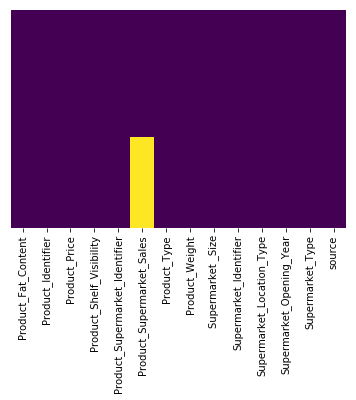

In [459]:
sns.heatmap(data.isnull(),cbar=False,cmap='viridis',yticklabels=False)

In [460]:
#Check the mean sales by type:
data.pivot_table(values='Product_Supermarket_Sales',index='Supermarket_Type')

,Product_Supermarket_Sales
Supermarket_Type,
Grocery Store,826.633867
Supermarket Type1,6442.040623
Supermarket Type2,5540.621680
Supermarket Type3,12561.189697


In [461]:
visibility_item_avg = data.pivot_table(values='Product_Shelf_Visibility',index='Product_Identifier')

In [463]:
def impute_visibility_mean(cols):
    visibility = cols[0]
    item = cols[1]
    if visibility == 0:
        return visibility_item_avg['Product_Shelf_Visibility'][visibility_item_avg.index == item]
    else:
        return visibility
    
print ('Original #zeros: %d'%sum(data['Product_Shelf_Visibility'] == 0))
data['Product_Shelf_Visibility'] = data[['Product_Shelf_Visibility','Product_Identifier']].apply(impute_visibility_mean,axis=1).astype(float)
print ('Final #zeros: %d'%sum(data['Product_Shelf_Visibility'] == 0))

Original #zeros: 526
Final #zeros: 0


In [464]:
data['Product_Visibility_MeanRatio'] = data.apply(lambda x: x['Product_Shelf_Visibility']/visibility_item_avg['Product_Shelf_Visibility'][visibility_item_avg.index == x['Product_Identifier']][0],axis=1).astype(float)
data['Product_Visibility_MeanRatio'].describe()

count    8522.000000
mean        1.061723
std         0.237092
min         0.678833
25%         0.903575
50%         1.000000
75%         1.055709
max         2.729420
Name: Product_Visibility_MeanRatio, dtype: float64

In [465]:
#Item type combine:
data['Product_Identifier'].value_counts()
data['Product_Type_Combined'] = data['Product_Identifier'].apply(lambda x: x[0:2])
data['Product_Type_Combined'] = data['Product_Type_Combined'].map({'FD':'Food',
                                                            'NC':'Non-Consumable',
                                                            'DR':'Drinks'})
data['Product_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1598
Drinks             799
Name: Product_Type_Combined, dtype: int64

In [466]:
data['Supermarket_Years'] = 2016 - data['Supermarket_Opening_Year']
data['Supermarket_Years'].describe()

count    8522.000000
mean       11.168153
std         8.372251
min         0.000000
25%         5.000000
50%        10.000000
75%        22.000000
max        24.000000
Name: Supermarket_Years, dtype: float64

In [467]:
print('Original Categories:')
print(data['Product_Fat_Content'].value_counts())

Original Categories:
Low Fat          5200
Normal Fat       3006
Ultra Low fat     316
Name: Product_Fat_Content, dtype: int64


In [468]:
data['Product_Fat_Content'] = data['Product_Fat_Content'].replace({'Ultra Low fat':'Low Fat'})
print('Modified Categories:')
print(data['Product_Fat_Content'].value_counts())

Modified Categories:
Low Fat       5516
Normal Fat    3006
Name: Product_Fat_Content, dtype: int64


In [469]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Product_Type_Combined'] == "Non-Consumable",'Product_Fat_Content'] = "Non-Edible"
data['Product_Fat_Content'].value_counts()

Low Fat       3918
Normal Fat    3006
Non-Edible    1598
Name: Product_Fat_Content, dtype: int64

In [470]:
data.head()

,Product_Fat_Content,Product_Identifier,Product_Price,Product_Shelf_Visibility,Product_Supermarket_Identifier,Product_Supermarket_Sales,Product_Type,Product_Weight,Supermarket _Size,Supermarket_Identifier,Supermarket_Location_Type,Supermarket_Opening_Year,Supermarket_Type,source,Product_Visibility_MeanRatio,Product_Type_Combined,Supermarket_Years
0,Low Fat,DRA12,357.54,0.068535,DRA12_CHUKWUDI010,709.08,Soft Drinks,11.6,Small,CHUKWUDI010,Cluster 3,2005,Grocery Store,train,2.144657,Drinks,11
1,Low Fat,DRA12,355.79,0.040912,DRA12_CHUKWUDI013,6381.69,Soft Drinks,11.6,High,CHUKWUDI013,Cluster 3,1994,Supermarket Type1,train,1.280248,Drinks,22
2,Low Fat,DRA12,350.79,0.041178,DRA12_CHUKWUDI017,6381.69,Soft Drinks,11.6,Small,CHUKWUDI017,Cluster 2,2014,Supermarket Type1,train,1.288562,Drinks,2
3,Low Fat,DRA12,355.04,0.041113,DRA12_CHUKWUDI018,2127.23,Soft Drinks,11.6,Medium,CHUKWUDI018,Cluster 3,2016,Supermarket Type2,train,1.286534,Drinks,0
4,Low Fat,DRA12,354.79,0.031956,DRA12_CHUKWUDI035,2481.77,Soft Drinks,11.6,Small,CHUKWUDI035,Cluster 2,2011,Supermarket Type1,train,1.000000,Drinks,5


In [471]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#New variable for outlet
#data['Supermarket'] = le.fit_transform(data['Supermarket_Identifier'])

var_mod = ['Product_Fat_Content','Product_Type','Supermarket_Location_Type','Supermarket _Size','Supermarket_Identifier','Supermarket_Type']
le = LabelEncoder()

for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [472]:
dataa = pd.get_dummies(data, columns = var_mod)

In [473]:
dataa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 50 columns):
Product_Identifier                8522 non-null object
Product_Price                     8522 non-null float64
Product_Shelf_Visibility          8522 non-null float64
Product_Supermarket_Identifier    8522 non-null object
Product_Supermarket_Sales         4990 non-null float64
Product_Weight                    8522 non-null float64
Supermarket_Opening_Year          8522 non-null int64
source                            8522 non-null object
Product_Visibility_MeanRatio      8522 non-null float64
Product_Type_Combined             8522 non-null object
Supermarket_Years                 8522 non-null int64
Product_Fat_Content_0             8522 non-null uint8
Product_Fat_Content_1             8522 non-null uint8
Product_Fat_Content_2             8522 non-null uint8
Product_Type_0                    8522 non-null uint8
Product_Type_1                    8522 non-null uint8
Product_Type_2 

In [474]:
#Drop the columns which have been converted to different types:
dataa.drop(['Product_Identifier','Product_Supermarket_Identifier','Product_Type_Combined','Supermarket_Opening_Year'],axis=1,inplace=True)

In [475]:
#Divide into test and train:
train_df = dataa.loc[dataa['source']=="train"]
test_df = dataa.loc[dataa['source']=="test"]

In [476]:
#Drop unnecessary columns:
test_df.drop(['Product_Supermarket_Sales','source'],axis=1,inplace=True)
train_df.drop(['source'],axis=1,inplace=True)

C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [477]:
#Export files as modified versions:
#train.to_csv("train_modified.csv",index=False)
#test.to_csv("test_modified.csv",index=False)

In [478]:
train = pd.read_csv("train_modified.csv")
test = pd.read_csv("test_modified.csv")

In [479]:
train_df.head()

,Product_Price,Product_Shelf_Visibility,Product_Supermarket_Sales,Product_Weight,Product_Visibility_MeanRatio,Supermarket_Years,Product_Fat_Content_0,Product_Fat_Content_1,Product_Fat_Content_2,Product_Type_0,...,Supermarket_Identifier_4,Supermarket_Identifier_5,Supermarket_Identifier_6,Supermarket_Identifier_7,Supermarket_Identifier_8,Supermarket_Identifier_9,Supermarket_Type_0,Supermarket_Type_1,Supermarket_Type_2,Supermarket_Type_3
0,357.54,0.068535,709.08,11.6,2.144657,11,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,355.79,0.040912,6381.69,11.6,1.280248,22,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,350.79,0.041178,6381.69,11.6,1.288562,2,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,355.04,0.041113,2127.23,11.6,1.286534,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,354.79,0.031956,2481.77,11.6,1.000000,5,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [480]:
y = train_df['Product_Supermarket_Sales']
X = train_df.drop(['Product_Supermarket_Sales'],axis=1)

In [481]:
cols = ['Product_Price','Product_Weight','Supermarket_Identifier_5','Product_Shelf_Visibility',
        'Supermarket_Type_0','Supermarket_Type_1']

In [482]:
#from sklearn import preprocessing
#X = pd.DataFrame(preprocessing.normalize(X[cols]))

#X = pd.DataFrame(preprocessing.scale(X))

In [483]:
X.head()

,Product_Price,Product_Shelf_Visibility,Product_Weight,Product_Visibility_MeanRatio,Supermarket_Years,Product_Fat_Content_0,Product_Fat_Content_1,Product_Fat_Content_2,Product_Type_0,Product_Type_1,...,Supermarket_Identifier_4,Supermarket_Identifier_5,Supermarket_Identifier_6,Supermarket_Identifier_7,Supermarket_Identifier_8,Supermarket_Identifier_9,Supermarket_Type_0,Supermarket_Type_1,Supermarket_Type_2,Supermarket_Type_3
0,357.54,0.068535,11.6,2.144657,11,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,355.79,0.040912,11.6,1.280248,22,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,350.79,0.041178,11.6,1.288562,2,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,355.04,0.041113,11.6,1.286534,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,354.79,0.031956,11.6,1.000000,5,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [484]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.3, random_state=123)

In [485]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_reg = xgb.XGBRegressor(learning_rate = 0.1,
                          max_depth = 2)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2881.000862


In [486]:
import sklearn 
sklearn.metrics.r2_score(y_test, preds)

0.5916672252299534

In [487]:
result = xg_reg.predict(test_df)

ValueError: feature_names mismatch: ['Product_Price', 'Product_Weight', 'Supermarket_Identifier_5', 'Product_Shelf_Visibility', 'Supermarket_Type_0', 'Supermarket_Type_1'] ['Product_Price', 'Product_Shelf_Visibility', 'Product_Weight', 'Product_Visibility_MeanRatio', 'Supermarket_Years', 'Product_Fat_Content_0', 'Product_Fat_Content_1', 'Product_Fat_Content_2', 'Product_Type_0', 'Product_Type_1', 'Product_Type_2', 'Product_Type_3', 'Product_Type_4', 'Product_Type_5', 'Product_Type_6', 'Product_Type_7', 'Product_Type_8', 'Product_Type_9', 'Product_Type_10', 'Product_Type_11', 'Product_Type_12', 'Product_Type_13', 'Product_Type_14', 'Product_Type_15', 'Supermarket_Location_Type_0', 'Supermarket_Location_Type_1', 'Supermarket_Location_Type_2', 'Supermarket _Size_0', 'Supermarket _Size_1', 'Supermarket _Size_2', 'Supermarket_Identifier_0', 'Supermarket_Identifier_1', 'Supermarket_Identifier_2', 'Supermarket_Identifier_3', 'Supermarket_Identifier_4', 'Supermarket_Identifier_5', 'Supermarket_Identifier_6', 'Supermarket_Identifier_7', 'Supermarket_Identifier_8', 'Supermarket_Identifier_9', 'Supermarket_Type_0', 'Supermarket_Type_1', 'Supermarket_Type_2', 'Supermarket_Type_3']
training data did not have the following fields: Product_Type_11, Supermarket_Identifier_7, Product_Type_14, Product_Type_5, Product_Type_6, Supermarket_Type_3, Product_Type_1, Supermarket_Years, Product_Type_0, Supermarket_Identifier_8, Product_Fat_Content_2, Supermarket_Identifier_0, Product_Type_15, Product_Type_7, Supermarket _Size_2, Supermarket_Location_Type_1, Supermarket_Identifier_3, Supermarket_Identifier_6, Supermarket_Identifier_1, Product_Type_8, Supermarket_Location_Type_0, Supermarket_Location_Type_2, Supermarket_Identifier_2, Product_Type_9, Product_Type_3, Supermarket_Type_2, Product_Type_12, Supermarket_Identifier_9, Product_Visibility_MeanRatio, Supermarket _Size_1, Product_Fat_Content_1, Supermarket_Identifier_4, Product_Type_2, Product_Fat_Content_0, Product_Type_4, Product_Type_13, Product_Type_10, Supermarket _Size_0

In [489]:
preds

array([ 3977.6333, 13967.012 , 12922.084 , ...,  7957.4653,  1273.0483,
        9078.493 ], dtype=float32)

In [212]:
submission = pd.DataFrame({'Product_Supermarket_Identifier':sample['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': result},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
submission.to_csv('x.csv',index=False)

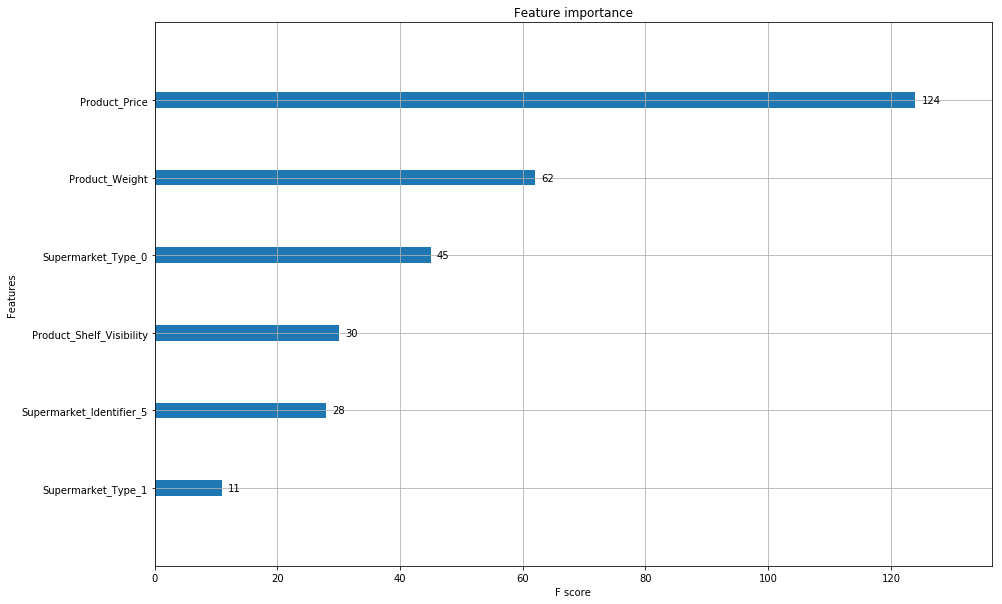

In [433]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [439]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

dt = DecisionTreeRegressor()
ada = AdaBoostRegressor()

gradboost = GradientBoostingRegressor()

ada.fit(X_train,y_train)
adapred = ada.predict(X_test)

gradboost.fit(X_train,y_train)
gradpred = gradboost.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, adapred))
print("RMSE(ada): %f" % (rmse))

rmse = np.sqrt(mean_squared_error(y_test, gradpred))
print("RMSE(grad): %f" % (rmse))

#ada.score(y_test, adapred)

RMSE(ada): 3228.843192
RMSE(grad): 2895.276933


In [440]:
import sklearn 
sklearn.metrics.r2_score(y_test, adapred)

0.4871133775857487

In [444]:
from sklearn import cross_validation, metrics
alg1 = LinearRegression(normalize=True)
alg1.fit(X_train,y_train)

cv_score = cross_validation.cross_val_score(gradboost, X_train,y_train, cv=5, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Predict training set:
cv_pred = gradboost.predict(X_test)

#Print model report:
print ("\nModel Report")
print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_test.values, cv_pred)))

#Predict on testing data:
#test_pred = alg1.predict(testdf)


C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)



Model Report
RMSE : 2895
CV Score : Mean - 2980 | Std - 172.2 | Min - 2768 | Max - 3178


C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [214]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(normalize=True)

In [215]:
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [216]:
lr_accuracy = round(lr.score(X_train,y_train) * 100,2)
lr_accuracy

54.36

In [217]:
rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print("RMSE: %f" % (rmse))

RMSE: 2937.371751


In [218]:
import sklearn 
sklearn.metrics.r2_score(y_test, preds)

0.5903583353978851

In [292]:
linear_submission = pd.DataFrame({'Product_Supermarket_Identifier':test_df['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': lr_pred},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
linear_submission.to_csv('linear_algo.csv',index=False)

In [293]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=15,min_samples_leaf=100)

tree.fit(X_train,Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
max_leaf_nodes=None, min_impurity_decrease=0.0,
min_impurity_split=None, min_samples_leaf=100,
min_samples_split=2, min_weight_fraction_leaf=0.0,
presort=False, random_state=None, splitter='best')

tree_pred = tree.predict(X_test)

tree_accuracy = round(tree.score(X_train,Y_train),2)
tree_accuracy

tree_submission = pd.DataFrame({'Product_Supermarket_Identifier':test_df['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': lr_pred},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

tree_submission.to_csv('tree_algo.csv',index=False)

In [372]:
traindf = pd.read_csv("train_modified.csv")
testdf = pd.read_csv("test_modified.csv")

In [376]:
traindf.head()

,Product_Price,Product_Shelf_Visibility,Product_Weight,Product_Visibility_MeanRatio,Supermarket_Years,Product_Fat_Content_0,Product_Fat_Content_1,Product_Fat_Content_2,Supermarket_Location_Type_0,Supermarket_Location_Type_1,...,Supermarket_0,Supermarket_1,Supermarket_2,Supermarket_3,Supermarket_4,Supermarket_5,Supermarket_6,Supermarket_7,Supermarket_8,Supermarket_9
0,357.54,0.068535,11.6,2.144657,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,355.79,0.040912,11.6,1.280248,22,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,350.79,0.041178,11.6,1.288562,2,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,355.04,0.041113,11.6,1.286534,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,354.79,0.031956,11.6,1.000000,5,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [374]:
Y_traindf = traindf['Product_Supermarket_Sales']
traindf = traindf.drop(['Product_Supermarket_Sales','Product_Supermarket_Identifier','Product_Identifier','Supermarket_Identifier'],axis=1)

testdf = testdf.drop(['Product_Supermarket_Identifier','Product_Identifier','Supermarket_Identifier'],axis=1)

In [375]:
testdf.head()

,Product_Price,Product_Shelf_Visibility,Product_Weight,Product_Visibility_MeanRatio,Supermarket_Years,Product_Fat_Content_0,Product_Fat_Content_1,Product_Fat_Content_2,Supermarket_Location_Type_0,Supermarket_Location_Type_1,...,Supermarket_0,Supermarket_1,Supermarket_2,Supermarket_3,Supermarket_4,Supermarket_5,Supermarket_6,Supermarket_7,Supermarket_8,Supermarket_9
0,459.98,0.214125,8.270,1.589432,11,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,464.98,0.127821,8.270,0.948808,22,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,477.38,0.082171,7.390,1.000542,22,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,472.63,0.011791,6.115,1.473415,11,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,473.13,0.007038,6.115,0.879552,22,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [386]:
from sklearn import cross_validation, metrics
alg1 = LinearRegression(normalize=True)
alg1.fit(traindf, Y_traindf)

cv_score = cross_validation.cross_val_score(alg1, traindf, Y_traindf, cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Predict training set:
dtrain_pred = alg1.predict(traindf)

#Print model report:
print ("\nModel Report")
print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(Y_traindf.values, dtrain_pred)))
print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

#Predict on testing data:
test_pred = alg1.predict(testdf)

C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)



Model Report
RMSE : 2957
CV Score : Mean - 2964 | Std - 210.2 | Min - 2531 | Max - 3349


C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [387]:
linear_submission2 = pd.DataFrame({'Product_Supermarket_Identifier':test_df['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': lr_pred},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
linear_submission2.to_csv('linear_algo2.csv',index=False)

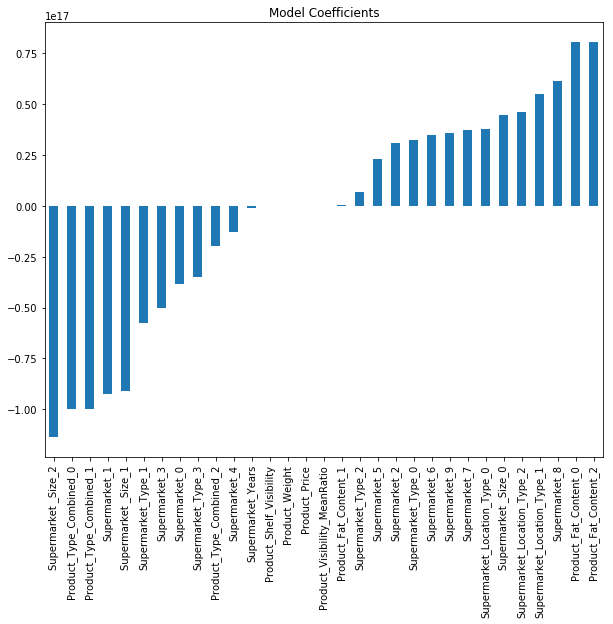

In [393]:
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients',figsize=[10,8])

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)



Model Report
RMSE : 2958
CV Score : Mean - 2964 | Std - 210.2 | Min - 2531 | Max - 3349


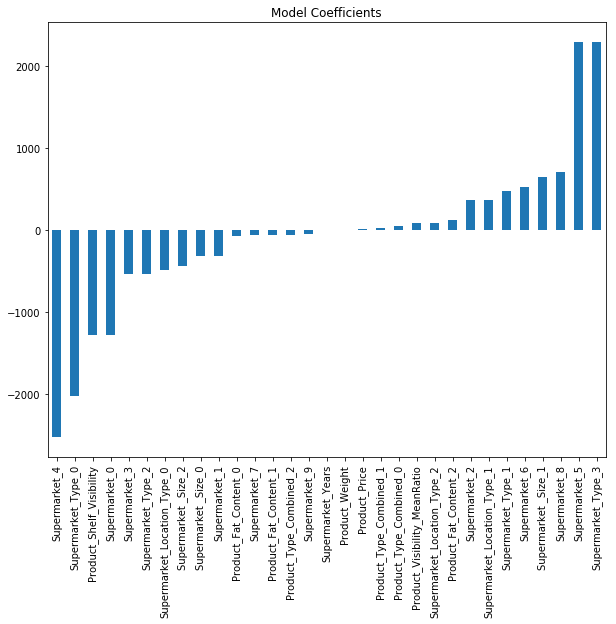

In [397]:
alg2 = Ridge(alpha=0.05,normalize=True)     

alg2.fit(traindf, Y_traindf)

cv_score2 = cross_validation.cross_val_score(alg2, traindf, Y_traindf, cv=20, scoring='mean_squared_error')
cv_score2 = np.sqrt(np.abs(cv_score))

#Predict training set:
dtrain_pred2 = alg2.predict(traindf)

#Print model report:
print ("\nModel Report")
print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(Y_traindf.values, dtrain_pred2)))
print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

#Predict on testing data:
test_pred2 = alg2.predict(testdf)

ridge_submission = pd.DataFrame({'Product_Supermarket_Identifier':test_df['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': lr_pred},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
ridge_submission.to_csv('ridge_algo.csv',index=False)

coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients',figsize=[10,8])

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)



Model Report
RMSE : 2958
CV Score : Mean - 2964 | Std - 210.2 | Min - 2531 | Max - 3349


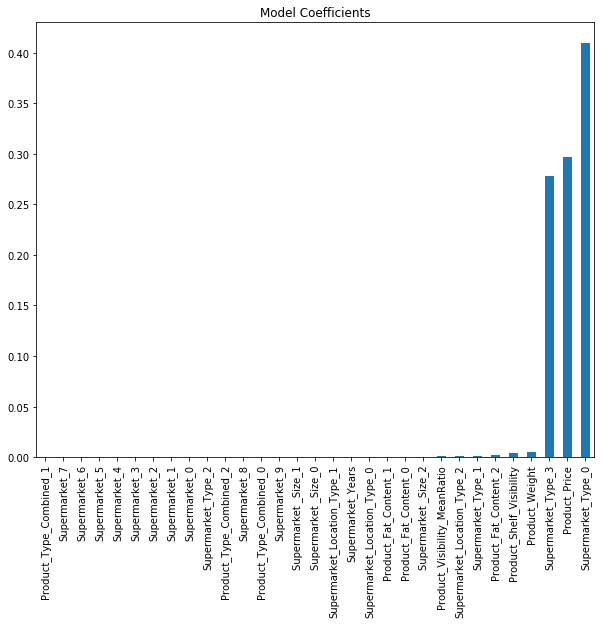

In [398]:
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)

alg3.fit(traindf, Y_traindf)

cv_score3 = cross_validation.cross_val_score(alg2, traindf, Y_traindf, cv=20, scoring='mean_squared_error')
cv_score3 = np.sqrt(np.abs(cv_score))

#Predict training set:
dtrain_pred3 = alg3.predict(traindf)

#Print model report:
print ("\nModel Report")
print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(Y_traindf.values, dtrain_pred2)))
print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

#Predict on testing data:
test_pred3 = alg3.predict(testdf)

dtr_submission = pd.DataFrame({'Product_Supermarket_Identifier':test_df['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': lr_pred},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
dtr_submission.to_csv('dtr_algo.csv',index=False)

coef4 = pd.Series(alg3.feature_importances_, predictors).sort_values()
coef4.plot(kind='bar', title='Model Coefficients',figsize=[10,8])

In [400]:
predictors = ['Product_Price','Supermarket_Type_0','Supermarket_Type_3','Product_Weight']
alg5 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)

alg5.fit(traindf, Y_traindf)

cv_score4 = cross_validation.cross_val_score(alg5, traindf, Y_traindf, cv=20, scoring='mean_squared_error')
cv_score4 = np.sqrt(np.abs(cv_score))

#Predict training set:
dtrain_pred5 = alg5.predict(traindf)

#Print model report:
print ("\nModel Report")
print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(Y_traindf.values, dtrain_pred2)))
print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

#Predict on testing data:
test_pred4 = alg5.predict(testdf)

dtr_submission = pd.DataFrame({'Product_Supermarket_Identifier':test_df['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': lr_pred},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
dtr_submission.to_csv('dtr_algo.csv',index=False)

coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)



Model Report
RMSE : 2958
CV Score : Mean - 2964 | Std - 210.2 | Min - 2531 | Max - 3349


ValueError: Wrong number of items passed 31, placement implies 4

In [377]:
#Define target and ID columns:
target = ['Product_Supermarket_Sales']
IDcol = ['Product_Supermarket_Identifier']
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    predxx1 = pd.DataFrame({ x: dtest[x] for x in IDcol})
    predxx1.to_csv(filename, index=False)